<a href="https://colab.research.google.com/github/ramonVDAKKER/teaching-quantitative-finance/blob/main/notebooks/illustration_discrete_time_delta_hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook illustration discrete-time implementation of delta-hedging strategy

## 0. Imports

In [93]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [94]:
%%capture
!git clone https://github.com/ramonVDAKKER/teaching-quantitative-finance
import os
os.chdir("teaching-quantitative-finance/notebooks")
from utils.black_scholes import BlackScholesOptionPrice

## 1. Example discrete-time delta-hedging

The setup is as follows:
*   we adopt the standard models for $B$ and $S$;
*   we consider a situation in which we are only allowed to trade on a discrete-time grid;
*   financial institution that has a position of $a$ put options with exercise price $K$ and maturity $T$ at $t=0$ (in case $a<0$ the institution sells (writes) the puts, in case $a>0$ the institution buys the options);
*   we will evaluate two strategies:
    1.   No active risk management: the institution takes no actions apart from investing $-a p_0$, with $p_0$ the price of one put at $t=0$, in the money-market-account $B$. This implies that there are no net cashflows in the time interval $[0,T)$. And at maturity $T$ the net cashflow equals $a\times (\max(K-S_T, 0) - p_0 \exp(rT))$ at maturity.
    2.   Delta-hedging: the institution trades in $S$ and $B$, at each point-in-time (on the discrete grid), such that a) the total portfolio (of the puts and the positions in $S$ and $B$) is delta-neutral and b) the rebalancing of the positions in $S$ and $B$ is budget-neutral.

*Remark:* Please recall that an implementation of 2) in continuous-time would imply that the total portfolio has value 0 at each point in time $t\in [0, T]$. This means that the institution would be able to take the position in the put (to serve its clients) without bearing any risk.




### Parameters

In [95]:
# granularity time grid [number of points per unit-of-time [=1 year]]:
num_time_steps_per_unit_of_time = 252
# parameters GBM for S:
S_0 = 100
mu = 0.05
sigma = 0.20
# parameters B:
B_0 = 1
r = 0.01
# put option specs:
T = 1
K = 90
num_puts = - 1000 # negative=instution writes puts (for client who wants to buy put), positive=institution buys puts (for client who wants to write put)

The following function implements the discrete-time delta hedging strategy as descibred above.

In [96]:
def writing_put_option_delta_hedge_discrete_time(K: float, T: float, S_0: float, mu: float, sigma: float,
                                                 B_0: float, r: float, num_time_steps_per_unit_of_time: int,
                                                num_puts: int
                                                 ):

    num_time_steps_total = int(T * num_time_steps_per_unit_of_time)
    time_delta = T / num_time_steps_total
    # intitialize variables:
    phi = np.zeros(num_time_steps_total + 1)
    psi = np.zeros(num_time_steps_total + 1)
    phi[-1] = np.nan
    psi[-1] = np.nan
    price_puts = np.zeros(num_time_steps_total + 1)
    S = np.zeros(num_time_steps_total + 1)
    S[0] = S_0
    B = np.zeros(num_time_steps_total + 1)
    B[0] = B_0
    total_portfolio_value = np.zeros(num_time_steps_total + 1)
    put = BlackScholesOptionPrice(K, r, sigma)
    time = np.linspace(0, T, num_time_steps_total + 1)
    # determine initial positions:
    put_price_initial = put.price_put(current_stock_price=S_0, time_to_maturity=T)
    price_puts[0] = num_puts * put_price_initial
    phi[0] = - num_puts * put.delta_put(current_stock_price=S_0, time_to_maturity=T) # make total portfolio delta-neutral
    psi[0] = - (price_puts[0] + phi[0] * S[0]) / B[0]
    total_portfolio_value[0] = price_puts[0] + phi[0] * S[0] + psi[0] * B[0] # 0 by construction
    # iterate over discrete-time grid:
    for k in range(1, num_time_steps_total + 1):
        # new asset prices:
        B[k] = B[k - 1] * np.exp(r * time_delta)
        S[k] = S[k - 1] * np.exp((mu - 0.5 * sigma ** 2) * time_delta + sigma * np.sqrt(time_delta) * norm.rvs())
        # current value of (S,B) portfolio from previous point-in-time (below we will rebalance):
        value = phi[k - 1] * S[k] + psi[k - 1] * B[k]
        # new value puts:
        if time[k] == T:
            price_puts[k] =  num_puts * np.maximum(K - S[k], 0)
            total_portfolio_value[k] = price_puts[k] + value
            break
        price_puts[k] = num_puts * put.price_put(current_stock_price=S[k], time_to_maturity=T - time[k])
        # determine new position S for next interval (such that combination of (S, B)-portfolio and
        # puts is delta-neutral):
        phi[k] =  - num_puts * put.delta_put(current_stock_price=S[k], time_to_maturity=T - time[k])
        # determine new position B, such that there is no net cashflow in (S, B)-portfolio:
        psi[k] = (value - phi[k] * S[k]) / B[k]
        # mismatch between discrete-time delta-neutral, self-financing portfolio and price puts:
        total_portfolio_value[k] = price_puts[k] + phi[k] * S[k] + psi[k] * B[k]
    return time, S, B, phi, psi, price_puts, total_portfolio_value

<Axes: title={'center': 'mismatch'}, xlabel='t'>

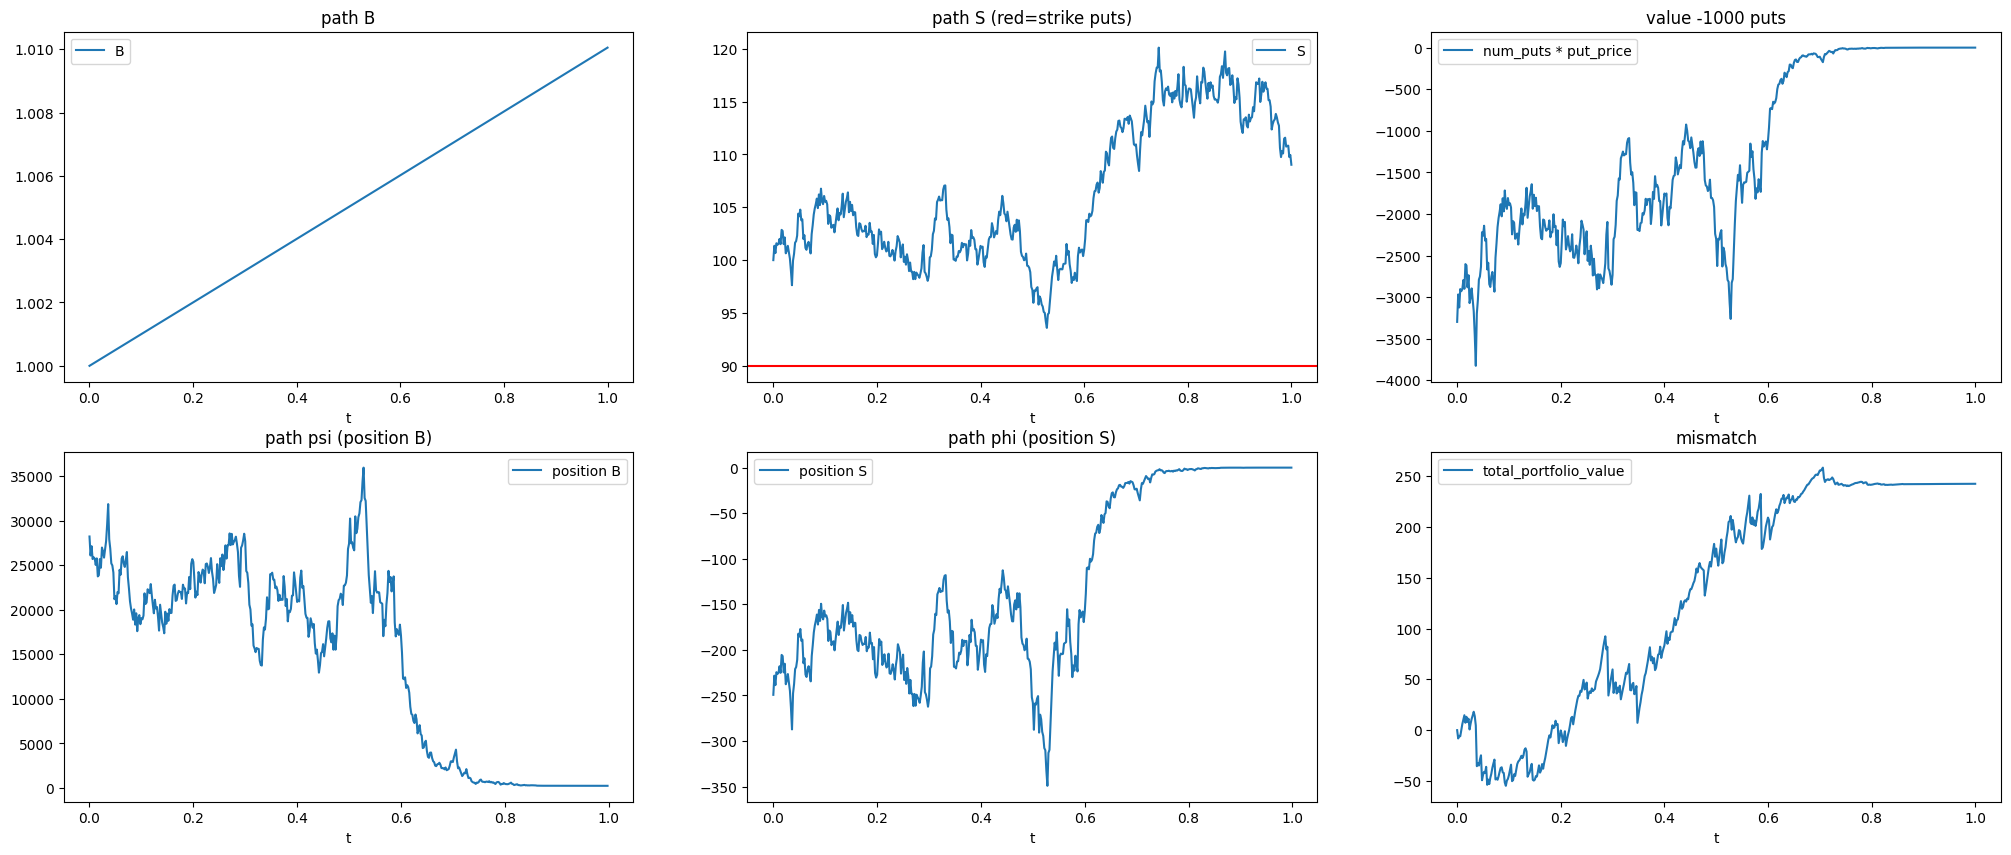

In [97]:
time, S, B, phi, psi, price_puts, total_portfolio_value = writing_put_option_delta_hedge_discrete_time(K, T, S_0, mu, sigma,
                                                 B_0, r, num_time_steps_per_unit_of_time,
                                                num_puts
                                                 )
df = pd.DataFrame(data = np.array([time, S, B, phi, psi, price_puts, total_portfolio_value]).T, columns=["t", "S", "B",
                                "position S", "position B", "num_puts * put_price", "total_portfolio_value"])
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
df.plot(x="t", y="B", title="path B", ax=ax[0, 0])
df.plot(x="t", y="S", title="path S (red=strike puts)", ax=ax[0, 1])
ax[0, 1].axhline(y=K, color="r")
df.plot(x="t", y="num_puts * put_price", title=f"value {num_puts} puts", ax=ax[0, 2])
df.iloc[:-1].plot(x="t", y="position B", title="path psi (position B)", ax=ax[1, 0])
df.iloc[:-1].plot(x="t", y="position S", title="path phi (position S)", ax=ax[1, 1])
df.plot(x="t", y="total_portfolio_value", title="mismatch", ax=ax[1, 2])

In [98]:
print(f"Total value of {num_puts} puts at t=0: {price_puts[0]}")

Total value of -1000 puts at t=0: -3297.4052507200254


Next we use Monte Carlo simulations (replications) to approximate the distribution of the total portfolio value (consisting of the puts and the positions in $S$ and $B$) at maturity $T$. We also determine the distribution corresponding to strategy 1).

**Remark:** please note that the implementation is very slow due to the use of a for-loop. In your own programs (for the assignment) you should try to avoid loops.

In [99]:
M  = 1000 # number of Monte Carlo replications
strategy_no_risk_management = np.zeros(M)
strategy_delta_hedge = np.zeros(M)
sims_S = np.zeros(M)
sims_C = np.zeros(M)

for sim in range(M):
    _, S, _, _, _, price_puts, total_portfolio_value = writing_put_option_delta_hedge_discrete_time(K, T, S_0, mu, sigma,
                                                 B_0, r, num_time_steps_per_unit_of_time, num_puts)
    sims_S[sim] = S[-1]
    sims_C[sim] = price_puts[-1] / num_puts
    strategy_no_risk_management[sim] = price_puts[-1] - price_puts[0] * np.exp(r * T)
    strategy_delta_hedge[sim] = total_portfolio_value[-1]

<Axes: title={'center': 'Distribution $C_T$'}, ylabel='Frequency'>

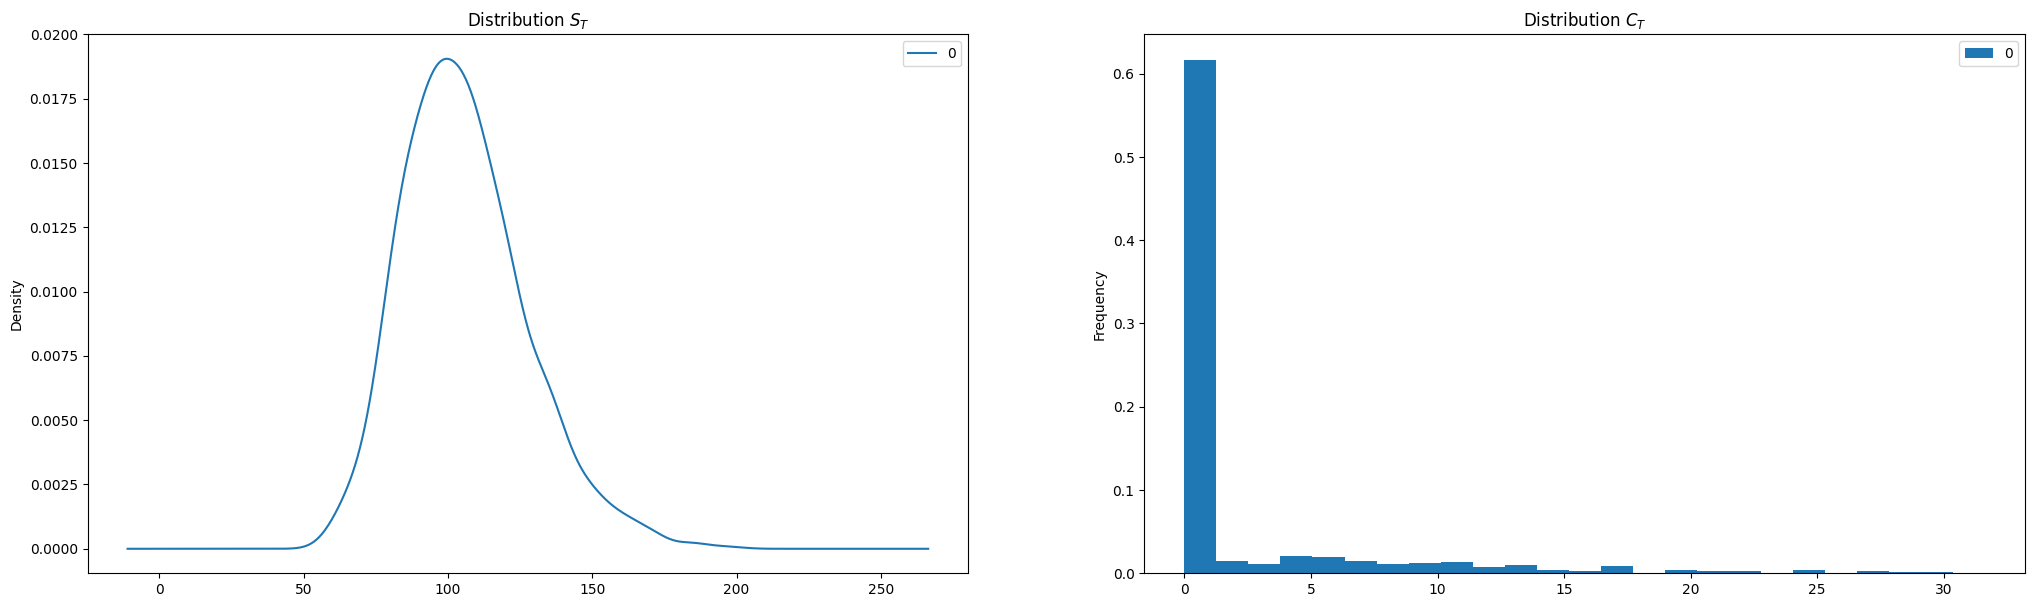

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
pd.DataFrame(sims_S).plot(kind="density", ax=axs[0], title="Distribution $S_T$")
pd.DataFrame(sims_C).plot(kind="hist", ax=axs[1], title="Distribution $C_T$", bins=25, density=True)

5% quantile no risk management: -10436
5% quantile delta hedging with frequency=500 per year: -406


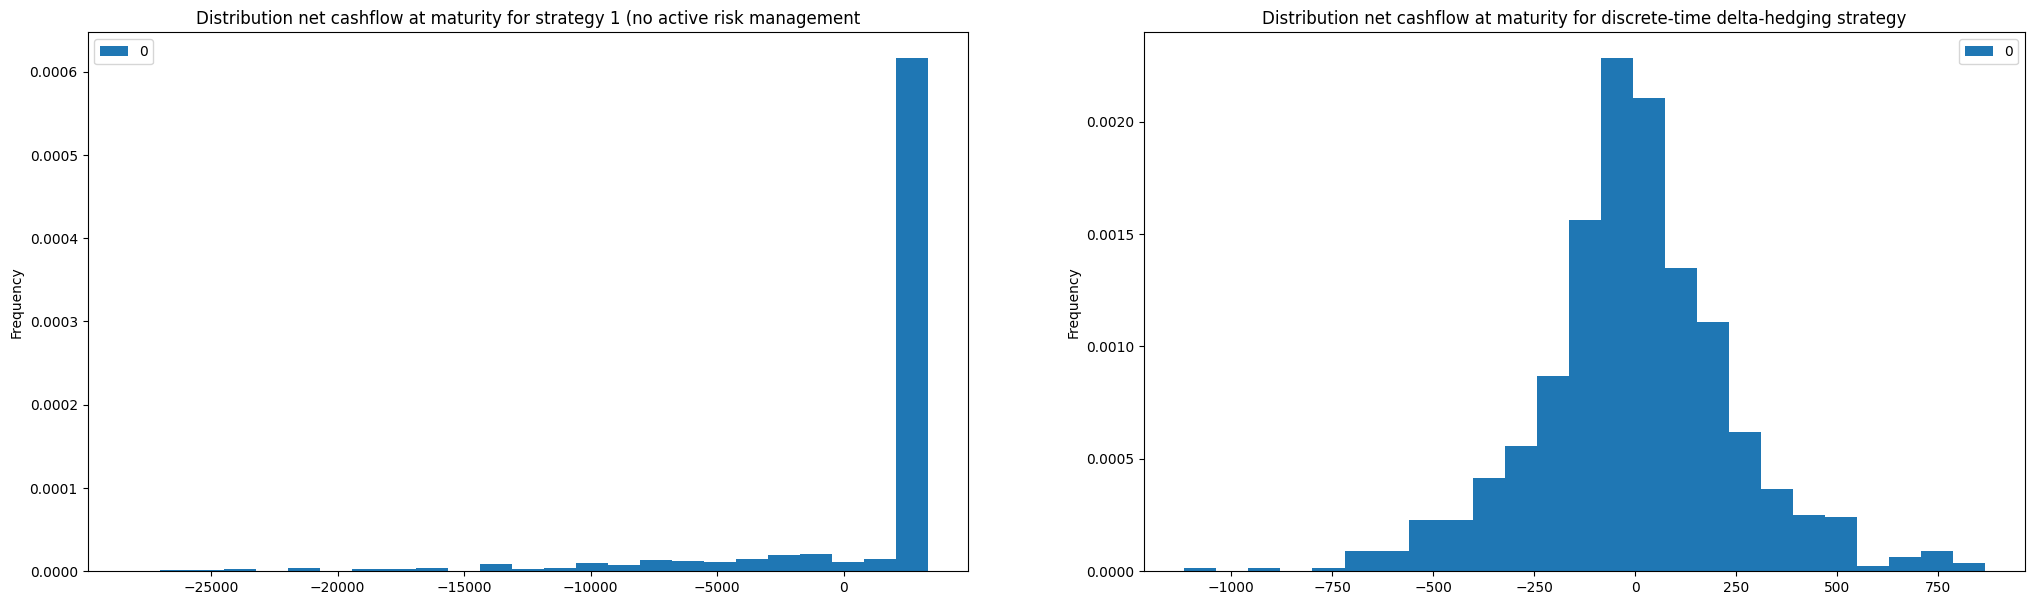

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
pd.DataFrame(strategy_no_risk_management).plot(kind="hist", ax=axs[0], title="Distribution net cashflow at maturity for strategy 1 (no active risk management", bins=25, density=True)
pd.DataFrame(strategy_delta_hedge).plot(kind="hist", ax=axs[1], title="Distribution net cashflow at maturity for discrete-time delta-hedging strategy", bins=25, density=True)
print(f"5% quantile no risk management: {round(np.quantile(strategy_no_risk_management, 0.05))}")
print(f"5% quantile delta hedging with frequency={num_time_steps_per_unit_of_time} per year: {round(np.quantile(strategy_delta_hedge, 0.05))}")